# Frame Prediction

Author: Noah Agudelo

Course Project, UC Irvine, Math 10, W22

## Introduction

Introduce your project here.  About 3 sentences.

This project explores the idea of frame prediction with pytorch.  The dataset is 200 sequences of 10 frames, each frame is 64x64 pixels and each pixel is greyscale.  Each sequence is made up of 2 moving numbers from the MNIST dataset.  The idea here is to train a neural network using this dataset and try to predict the 10th frame of various sequences in the dataset.

## Main portion of the project

(You can either have all one section or divide into multiple sections)

### Imports

In [ ]:
# Imports used for most of the project.
import numpy as np
import pandas as pd
import altair as alt

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [ ]:
!pip install ipywidgets==7.6.5

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Imports used for displaying a sequence of the dataset.
import matplotlib.pyplot as plt

import io
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [ ]:
# Imports used for the initial download of the data.
import tensorflow as tf
from tensorflow import keras

### The initial download of the data.  
Download the dataset and save it as to not download it again when working with it later on.

In [ ]:
# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

np.save("dataset.npy", dataset)

819216384/819200096 [==============================] - 14s 0us/step


In [ ]:
dataset = np.load("dataset.npy")[:100].astype(float)

In [ ]:
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# Split the data into half and append the half to the dataset
# Remove the last frame and make that the y.
def create_X_y(data):
    mid = int(data.shape[1]/2 - 1)
    X = np.append(data[:, 0 : mid, :, :],data[:,mid+1:-1,:,:],axis=0)
    y = np.append(data[:, mid, :, :],data[:,-1,:,:],axis=0)
    return X, y

# Apply the processing function to the datasets.
X_train, y_train = create_X_y(train_dataset)
X_val, y_val = create_X_y(val_dataset)

We save and load the training and validation sets here to save time when working with the project later.

In [ ]:
# Save the dataset.
np.save("X_train.npy",X_train)
np.save("y_train.npy",y_train)
np.save("X_val.npy",X_val)
np.save("y_val.npy",y_val)

In [ ]:
# Load the dataset.
X_train = np.load("X_train.npy").astype(float)
y_train = np.load("y_train.npy").astype(float)
X_val = np.load("X_val.npy").astype(float)
y_val = np.load("y_val.npy").astype(float)

The original dataset has 100 samples of sequences, with 20 frames each.  We split each sequence into two, effectively making the dataset 200 samples of 10 frame sequences.  This was done to save memory.

In [ ]:
# Inspect the dataset.
print(f"Original Dataset Shape: {dataset.shape}")
print(f"Original Training Dataset Shape: {train_dataset.shape}")
print(f"Original Validation Dataset Shape: {val_dataset.shape}")

Original Dataset Shape: (100, 20, 64, 64, 1)
Original Training Dataset Shape: (90, 20, 64, 64, 1)
Original Validation Dataset Shape: (10, 20, 64, 64, 1)


In [ ]:
print(f"Modified Training Dataset Shapes: {X_train.shape}, {y_train.shape}")
print(f"Modified Validation Dataset Shapes: {X_val.shape}, {y_val.shape}")

Modified Training Dataset Shapes: (180, 9, 64, 64, 1), (180, 64, 64, 1)
Modified Validation Dataset Shapes: (20, 9, 64, 64, 1), (20, 64, 64, 1)


We create a custom iterable class in order to create batches of the dataset.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset_X, dataset_y, transform=None, target_transform=None):
        self.data_X = dataset_X
        self.data_y = dataset_y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data_X)

    def __getitem__(self, idx):
        X = self.data_X[idx]
        y = self.data_y[idx]
        if self.transform:
            X = self.transform(X)
        if self.target_transform:
            y = self.target_transform(y)
        return X, y

In [ ]:
batch_size = 5

train_dataloader = DataLoader(CustomDataset(X_train,y_train), batch_size=batch_size)
test_dataloader = DataLoader(CustomDataset(X_val,y_val), batch_size=batch_size)

X, y = next(iter(train_dataloader))
print(f"Shape of X:\n{X.shape}")

print("")

print(f"Shape of y:\n{y.shape}")

Shape of X:
torch.Size([5, 9, 64, 64, 1])

Shape of y:
torch.Size([5, 64, 64, 1])


PyTorch has LSTM layers, which probably would have helped making the neural network more accurate in predicting the last frame.  However, we instead use two linear layers to keep things more simple.  
I also ran out of memory when using more than 2 linear layers, and so I reduced it to only two layers.

In [ ]:
class Frames(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(9*64*64, 2*64*64),
            nn.ReLU(),
            nn.Linear(2*64*64, 64*64),
            nn.Sigmoid()
        )

    def forward(self, x) :
        return self.layers(self.flatten(x))

In [ ]:
my_nn = Frames()

In [ ]:
loss_fn = nn.MSELoss()

In [ ]:
optimizer = torch.optim.SGD(my_nn.parameters(), lr=0.25)

We train the neural network on the dataset while keeping track of the loss along the way.

In [ ]:
epochs = 20

training_loss = np.zeros(epochs)
test_loss = np.zeros(epochs)

In [ ]:
for i in range(epochs):
    for X,y in train_dataloader:
        X = X.float()
        y = y.float()
        loss = loss_fn(my_nn(X),y.flatten(1,3))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Training loss:\n{loss}") # We only print one loss per epoch
    training_loss[i] = loss.item()

    for X,y in test_dataloader:
        X = X.float()
        y = y.float()
        loss = loss_fn(my_nn(X),y.flatten(1,3))
        print(f"Test loss:\n{loss}")
        test_loss[i] = loss.item()
        break # We only compute and print one test loss per epoch

    print("")

Training loss:
0.23940129578113556
Test loss:
0.23851247131824493

Training loss:
0.23201878368854523
Test loss:
0.23074856400489807

Training loss:
0.21782059967517853
Test loss:
0.2155887633562088

Training loss:
0.1911080926656723
Test loss:
0.18724694848060608

Training loss:
0.15148711204528809
Test loss:
0.14617511630058289

Training loss:
0.1117292195558548
Test loss:
0.10660617053508759

Training loss:
0.08406315743923187
Test loss:
0.08047157526016235

Training loss:
0.06786681711673737
Test loss:
0.06595981121063232

Training loss:
0.0584770068526268
Test loss:
0.057928383350372314

Training loss:
0.05274160951375961
Test loss:
0.05320139601826668

Training loss:
0.04901493713259697
Test loss:
0.05021515488624573

Training loss:
0.046455468982458115
Test loss:
0.0482061505317688

Training loss:
0.04461423307657242
Test loss:
0.04678148403763771

Training loss:
0.04323801398277283
Test loss:
0.045726608484983444

Training loss:
0.04217633605003357
Test loss:
0.0449173226952552

In [ ]:
# Save the loss to file.
np.save("training_loss.npy", training_loss)
np.save("test_loss.npy", test_loss)

In [ ]:
# Load the loss from file.
training_loss = np.load("training_loss.npy")
test_loss = np.load("test_loss.npy")

In [ ]:
scores = pd.DataFrame({"Epoch":range(1,epochs+1), "train_loss":training_loss, "test_loss":test_loss})
scores.head()

,Epoch,train_loss,test_loss
0,1,0.239401,0.238512
1,2,0.232019,0.230749
2,3,0.217821,0.215589
3,4,0.191108,0.187247
4,5,0.151487,0.146175


Here, we plot loss over each epoch for both the test loss and training loss.

In [ ]:
alt.Chart(scores).mark_line().encode(
    x= alt.X("Epoch", scale = alt.Scale(nice=False, domain = (1,20))),
    y=alt.Y('value:Q', title="Loss", scale = alt.Scale(zero=False)),
    color=alt.Color("key:N",title="Legend")
).transform_fold(
    fold=["train_loss", "test_loss"]
).properties(
    title="Test Loss vs Train Loss",
    width = 1000,
    height = 500
)

alt.Chart(...)

Now, we take a look at a predicted output and see what it looks like.

In [ ]:
pred = my_nn(X)

In [ ]:
pred = pred.reshape([5, 64, 64, 1])
print(X.shape)
print(y.shape)
print(pred.shape)

torch.Size([5, 9, 64, 64, 1])
torch.Size([5, 64, 64, 1])
torch.Size([5, 64, 64, 1])


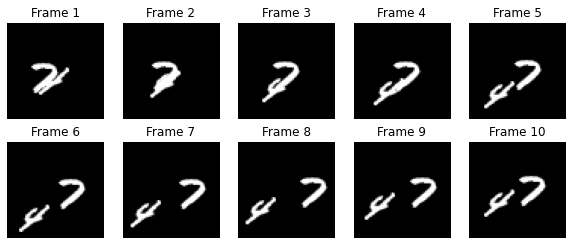

In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Plot each of the sequential images for one random data example.
for idx, ax in enumerate(axes.flat):
    if idx != 9:
        ax.imshow(np.squeeze(X[0][idx]), cmap="gray")
    else:
        ax.imshow(np.squeeze(y[0]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Display the figure.
plt.show()

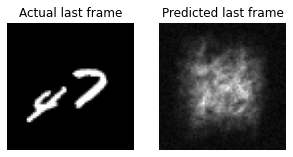

In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

# Plot each of the sequential images for one random data example.

axes[0].imshow(np.squeeze(y[0].detach().numpy()), cmap="gray")
axes[0].set_title("Actual last frame")
axes[0].axis("off")

axes[1].imshow(np.squeeze(pred[0].detach().numpy()), cmap="gray")
axes[1].set_title("Predicted last frame")
axes[1].axis("off")

# Print information and display the figure.
plt.show()

## Summary

The test loss is smaller than the training loss, which seems odd to the neural network is training to reduce training loss, not test loss.  
I also assumed the predicted last frame would look more recognizable when comparing it to the actual last frame.  
To improve the neural network, perhaps it should include some layer that more strictly returns greyscale pixels closer to black or full white, since each actual frame has very distinct bright numbers with black background.  It could also include an LSTM layer, which takes previous guesses and previous correct answers into account when predicting a frame in the sequence.

## References

Include references that you found helpful.  Also say where you found the dataset you used.

Download and cleaning of the dataset, matplotlib examples, etc. from Keras tutorial on frame prediction:  
https://keras.io/examples/vision/conv_lstm/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e7d25786-d0b6-46ff-ae9c-55a1da4c0726' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>